In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time, datetime
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import tensorflow as tf

Using TensorFlow backend.


 import passed tf version  1.3.0


In [48]:
filename='ticker_ana.csv'
print(filename)
col_names = ['Date','Ticker']
def get_stock_data(filename, col_name):  
    stocks = pd.read_csv(filename, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    df.drop(df.columns[[0]], axis=1, inplace=True) 
    return df

ticker_ana.csv


In [49]:
df = get_stock_data(filename,col_names)
#Setting X and Y for training and testing
lag=5
window = 23 #sequence length
nfeatures=df.shape[1]
neurons = [32, 128, 32, 16, 1]
import copy
normRdf=copy.deepcopy(df)
normRdf = (df-df.mean())/df.std()


In [50]:
def process_batch(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    print('data len=',len(data))
    for index in range(len(data) - sequence_length+1):
        result.append(data[index: index + seq_len+1])
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:row, :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[row:, :-1]
    y_test = result[row:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    return [x_train, y_train, x_test, y_test]

In [51]:
X_train, y_train, X_test, y_test = process_batch(normRdf, window) #reversed df and then passed to load_data

data len= 601


In [52]:
#Building model functions
def build_model2(layers, neurons): 
        d = 0.2
        model = Sequential()
        model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(neurons[3], input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d)) 
        model.add(Dense(neurons[4],kernel_initializer='normal',activation='linear'))
        start = time.time()
        rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
        model.compile(loss='mse',optimizer=rmsprop,metrics=['accuracy'])
        return model

In [60]:
#Loading the model sequence structure and compile it 
batch_size=64
epochs=512
print(columns)
title= str(batch_size)+' epochs='+str(epochs)
print(str(neurons)+' title='+title)
from keras.optimizers import RMSprop
model = build_model2([nfeatures,window,1],neurons)

Ticker
[32, 128, 32, 16, 1] title=64 epochs=512


In [61]:
#Executing the model & RMS/RMSE results
history=model.fit(
    X_train,
    y_train,
    batch_size=batch_size, #was 512
    epochs=epochs, #was 512
    validation_split=0.1,
    verbose=0)
print('fit done')

fit done


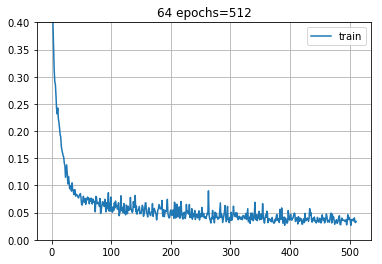

In [62]:
plt2.plot(history.history['loss'], label='train')
plt2.title(title)
plt2.legend(loc='best')
plt2.ylim(0.0,0.4)
plt2.grid(True)
plt2.show()

Train Error: 0.01402 MSE (0.12 RMSE)
Test Error: 0.00302 MSE (0.05 RMSE)
y_test: 0.56926 MSE


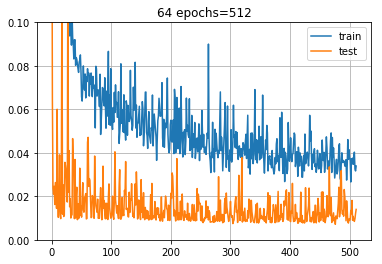

In [63]:
trainError = model.evaluate(X_train, y_train, verbose=0)
print('Train Error: %.5f MSE (%.2f RMSE)' % (trainError[0], math.sqrt(trainError[0])))
testError = model.evaluate(X_test, y_test, verbose=0)
print('Test Error: %.5f MSE (%.2f RMSE)' % (testError[0], math.sqrt(testError[0])))
print('y_test: %.5f MSE'% ((y_test-0)**2).mean())
plt2.plot(history.history['loss'], label='train')
plt2.plot(history.history['val_loss'], label='test')
plt2.legend(loc='best')
plt2.ylim(0.0,0.1)
plt2.grid(True)
plt2.title(title)
plt2.show()

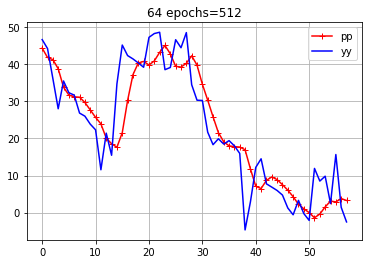